In [1]:
from glob import glob
import numpy as np
import scipy as sp
import json
import os
import matplotlib.pyplot as plt

os.chdir("../")

from src.detectors import gcc_phat_detector
from src.tdoa_matrix_to_tdoa_vector import mst_ransac_tdoa_matrix_to_tdoa_vector

In [169]:
input_folder = "./data/tdoa_20201016/data/music_0012/"
gcc_phat_detector(input_folder, window_length=30000)
detections = np.load(input_folder + "detections.npy")

n_detection_windows = detections.shape[0]
n_mics = detections.shape[1]


(-3.0, 3.0)

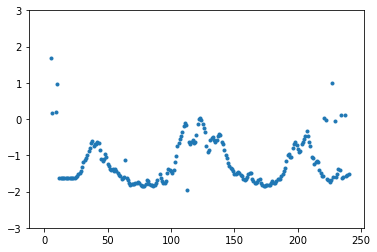

In [170]:
# Example plot
plt.plot(detections[:, 4, 6], '.')
plt.ylim([-3, 3])


In [171]:


tdoav = np.zeros((n_detection_windows, n_mics))
scores = np.zeros(n_detection_windows)
for i in range(n_detection_windows):

    tdoam = detections[i, :, :]
    res = mst_ransac_tdoa_matrix_to_tdoa_vector(tdoam)
    tdoav[i] = res[0]
    scores[i] = res[1]


(-5.0, 5.0)

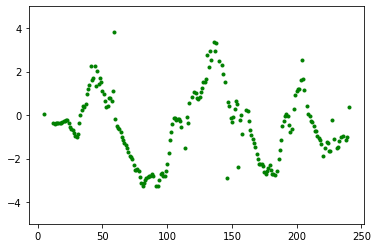

In [172]:
mic1 = 1
mic2 = 7
cutoff = n_mics*(n_mics-1)/2
x_index = np.arange(n_detection_windows)

# plt.plot(x_index[scores <= cutoff],tdoav[scores <= cutoff, mic1] - tdoav[scores <= cutoff, mic2], 'r.')
plt.plot(x_index[scores > cutoff], tdoav[scores > cutoff,
         mic1] - tdoav[scores > cutoff, mic2], 'g.')
plt.ylim([-5, 5])
